# **Modelling and Evaluating**

## Objectives

Achieve business requirement no. 2:

* The client is interested to tell wheterh a given leaf is covered with powdery mildew


## Inputs

- image shape embeddings (pickle file)
- Images from the test, train, validation folders and their subfolders. 
    ```bash
    . 
    ├── inputs 
    │   └──cherryleaves_dataset 
    │      └──cherry-leaves                                     
    │           ├── test
    │           │   ├── healthy
    │           │   └── powdery_mildew                   
    │           ├── train
    │           │   ├── healthy
    │           │   └── powdery_mildew          
    │           └── validation
    │               ├── healthy
    │               └── powdery_mildew                 
    └── ...
    ```

## Output

* Distribution plot of images in the training, validation, and test sets.

    * Label distribution - bar chart
    * Set distribution - pie chart (percentages)

* Image augmentation.

    * Display augmented images for each set.

* Class indices to modify prediction inference in labels.
* Development of a machine learning model and presentation of its summary.
* Training the model.
* Saving the model.
* Learning curve plot for model performance.

    * Model A - separate plots for accuracy and loss
    * Model B - overall model history plot
    * Model C - model history plot using Plotly

* Evaluation of the model on the saved file.

    * Calculate accuracy
    * Plot ROC curve
    * Generate classification report (Model A)
        * Model B - classification report with macro average and weighted average
        * Model C - synthetic classification report for each label

* Plot confusion matrix
* Save evaluation as a pickle file
* Make predictions on a random image file.

## Comments 

* The same data was visualized in various formats to address potential client requests for deeper insights. 
* The CNN was developed with the goal of maximizing accuracy while minimizing loss and training duration. 

## Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

## Set working directory

In [2]:
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
work_dir = os.getcwd()
work_dir

'/workspace/mildew-leaves-detection'

In [3]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-leaves-detection'

## Set input directories

Set train, validation and test paths

In [4]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [6]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [7]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
print(f"Input image shape: Width:({image_shape[0]}), Height:({image_shape[1]}), Channels:({image_shape[2]})")
image_shape

Input image shape: Width:(256), Height:(256), Channels:(3)


(256, 256, 3)

---

## Distribution of Images Across Datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




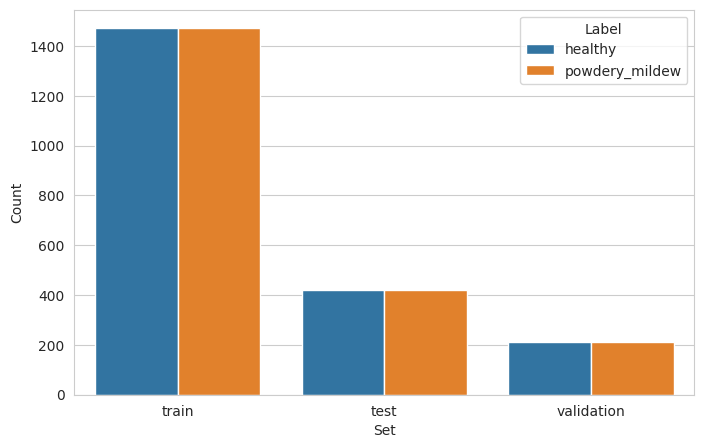

In [10]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Count', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image Data Preparation and Augmentation

### Import ImageDataGenerator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Image data augmentation


In [35]:
batch_size = 32

train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )


validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )
                                                                        

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image set

(32, 256, 256, 3)


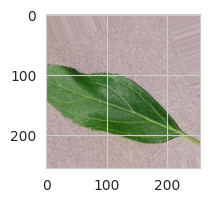

(32, 256, 256, 3)


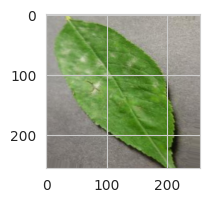

(32, 256, 256, 3)


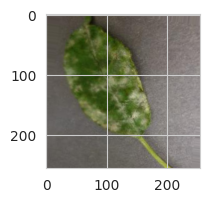

In [36]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Plot augmented validation image set

(32, 256, 256, 3)


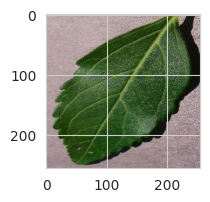

(32, 256, 256, 3)


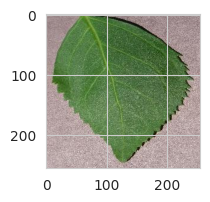

(32, 256, 256, 3)


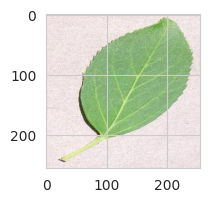

In [37]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Plot augmented test image set

(32, 256, 256, 3)


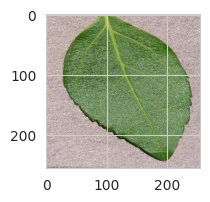

(32, 256, 256, 3)


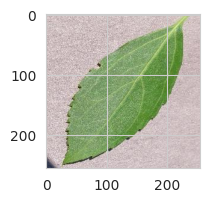

(32, 256, 256, 3)


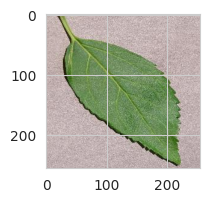

In [38]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [39]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---